# Analysis of the Data

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scienceplots

Select time and turns

In [10]:
# Try few turns +> much clearer peak at 0.46, no 0.39 peak showing
time = 1.5e-8
min_turn = 2000
max_turn = 4000

# Start of bunch => 0.46 peak is only clear at high intensity
time = -3e-8
min_turn = 2000
max_turn = 4000

# End of bunch => 0.46 and 0.38 peak clear at higher intensity
time = 6e-8
min_turn = 2000
max_turn = 8000

# End of bunch => 0.38 clearer at low intensity, then 0.46 becomes clearer at higher intensity
    # Need a wide range 0-10000 to see the 0.38 peak
time = 6e-8
min_turn = 6000
max_turn = 80000

# Half way though bunch => Clear peaks for all
time = 1.5e-8
min_turn = 0
max_turn = 10000

Calculate Intensity and Identify Tune Frequency

In [11]:
booster_turns = [2,4,6,8,10,11,14]
Max_Frequency = np.zeros((len(booster_turns),5))
Intensity = np.zeros((len(booster_turns),5))

# Gaussian function for fit
def gaussian(x, amplitude, mean, std_dev, c):
    return amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2)) + c


for t, turns in enumerate(booster_turns):
    for repeat in range(5):
        #print("Booster Turns: ",turns)
    
        # Calculate average intensity in the 0.04s around 0.57s
        try:
            intensity_data = np.loadtxt(r'C:\\Users\bengl\Documents\summerIntern\data_studies\\' + str(turns) + r'turns'+str(repeat)+'_beam')
            AB = np.load(r'C:\\Users\bengl\Documents\summerIntern\data_studies\\coherent_tune_shift\\'+str(turns)+r'turns00' +str(repeat)+'.npy',allow_pickle=True)
        except:
            continue
        mask = (intensity_data[0:,0] > 0.55) & (intensity_data[0:,0] < 0.59)
        Averaged_Intensity = np.mean(intensity_data[0:,1][mask])
        
    
        # Calculate the position
        time_along_bunch = np.linspace(-0.75e-7,0.75e-7,7500)
        AmB = AB[0]
        ApB = -1*AB[1]+50
        position = AmB/ApB
    
        """
        fig,ax = plt.subplots(3,1,dpi=100,sharex=True, figsize=(4,4))

        ax[0].plot(time_along_bunch,AmB[4000])
        ax[1].plot(time_along_bunch,ApB[4000])
        ax[2].plot(time_along_bunch,position[4000])
        ax[0].set_xlabel('Time (s)')
        ax[0].set_ylabel('A-B (Volt)')
        ax[1].set_ylabel('A+B (Volt)')
        ax[2].set_ylabel('A-B/A+B (Distance)')
        plt.show()
        """
    
        # Find position at a given time for each turn
        time_index = np.argmin(np.abs(time_along_bunch - time))
        """
        plt.plot(position[:, time_index])
        plt.xlabel('Turn')
        plt.ylabel('Position')
        plt.show()
        """
    
        # Fourier transform the position data
        position_at_time = position[:, time_index]
        position_slice = position_at_time[min_turn:max_turn]
        fourier = np.fft.fft(position_slice)
        freq = np.fft.fftfreq(len(position_slice))
    
        # Look in certain range
        mask = (freq>0.44) & (freq<0.48)
        freq_range = freq[mask]
        fourier_range = np.abs(fourier[mask])

        # Fit a gaussian to the peak
        p0 = [1.4, 0.460, 0.005, 0.07]  # Initial guess for the parameters
        fit_params, _ = curve_fit(gaussian, freq_range, fourier_range, p0=p0)
        amplitude_fit, mean_fit, std_dev_fit, c_fit = fit_params
        fitted_curve = gaussian(freq_range, amplitude_fit, mean_fit, std_dev_fit, c_fit)

        # Plotting
        """"
        plt.plot(freq_range, fourier_range, label='Fourier Transformed Data')
        plt.plot(freq_range, fitted_curve, label='Fitted Curve')
        plt.title('Fourier Transform of Position at time = ' + str(time) + 's')
        plt.xlabel('Frequency')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()
        """
        
        Max_Frequency[t][repeat] = mean_fit
        Intensity[t][repeat] = Averaged_Intensity


Calculate averages and Standard Deviations

In [12]:
Intensity_Avg = np.zeros(len(booster_turns))
Intensity_Std = np.zeros(len(booster_turns))
Max_Frequency_Avg = np.zeros(len(booster_turns))
Max_Frequency_Std = np.zeros(len(booster_turns))
for i in range(len(booster_turns)):
    I_list = Intensity[i,:][Intensity[i,:]>0]
    Intensity_Std[i] = np.std(I_list)
    Intensity_Avg[i] = np.mean(I_list)

    list = Max_Frequency[i,:][Max_Frequency[i,:]>0]
    Max_Frequency_Avg[i] = np.mean(list)
    Max_Frequency_Std[i] = np.std(list)
    
# Only one data point for 4 turns so use sigma from the fit and sigma in intensity as max of the others
Max_Frequency_Std[1] = 0.00111583
Intensity_Std[1]=max(Intensity_Std)

## Fitting
#### Regular Fitting

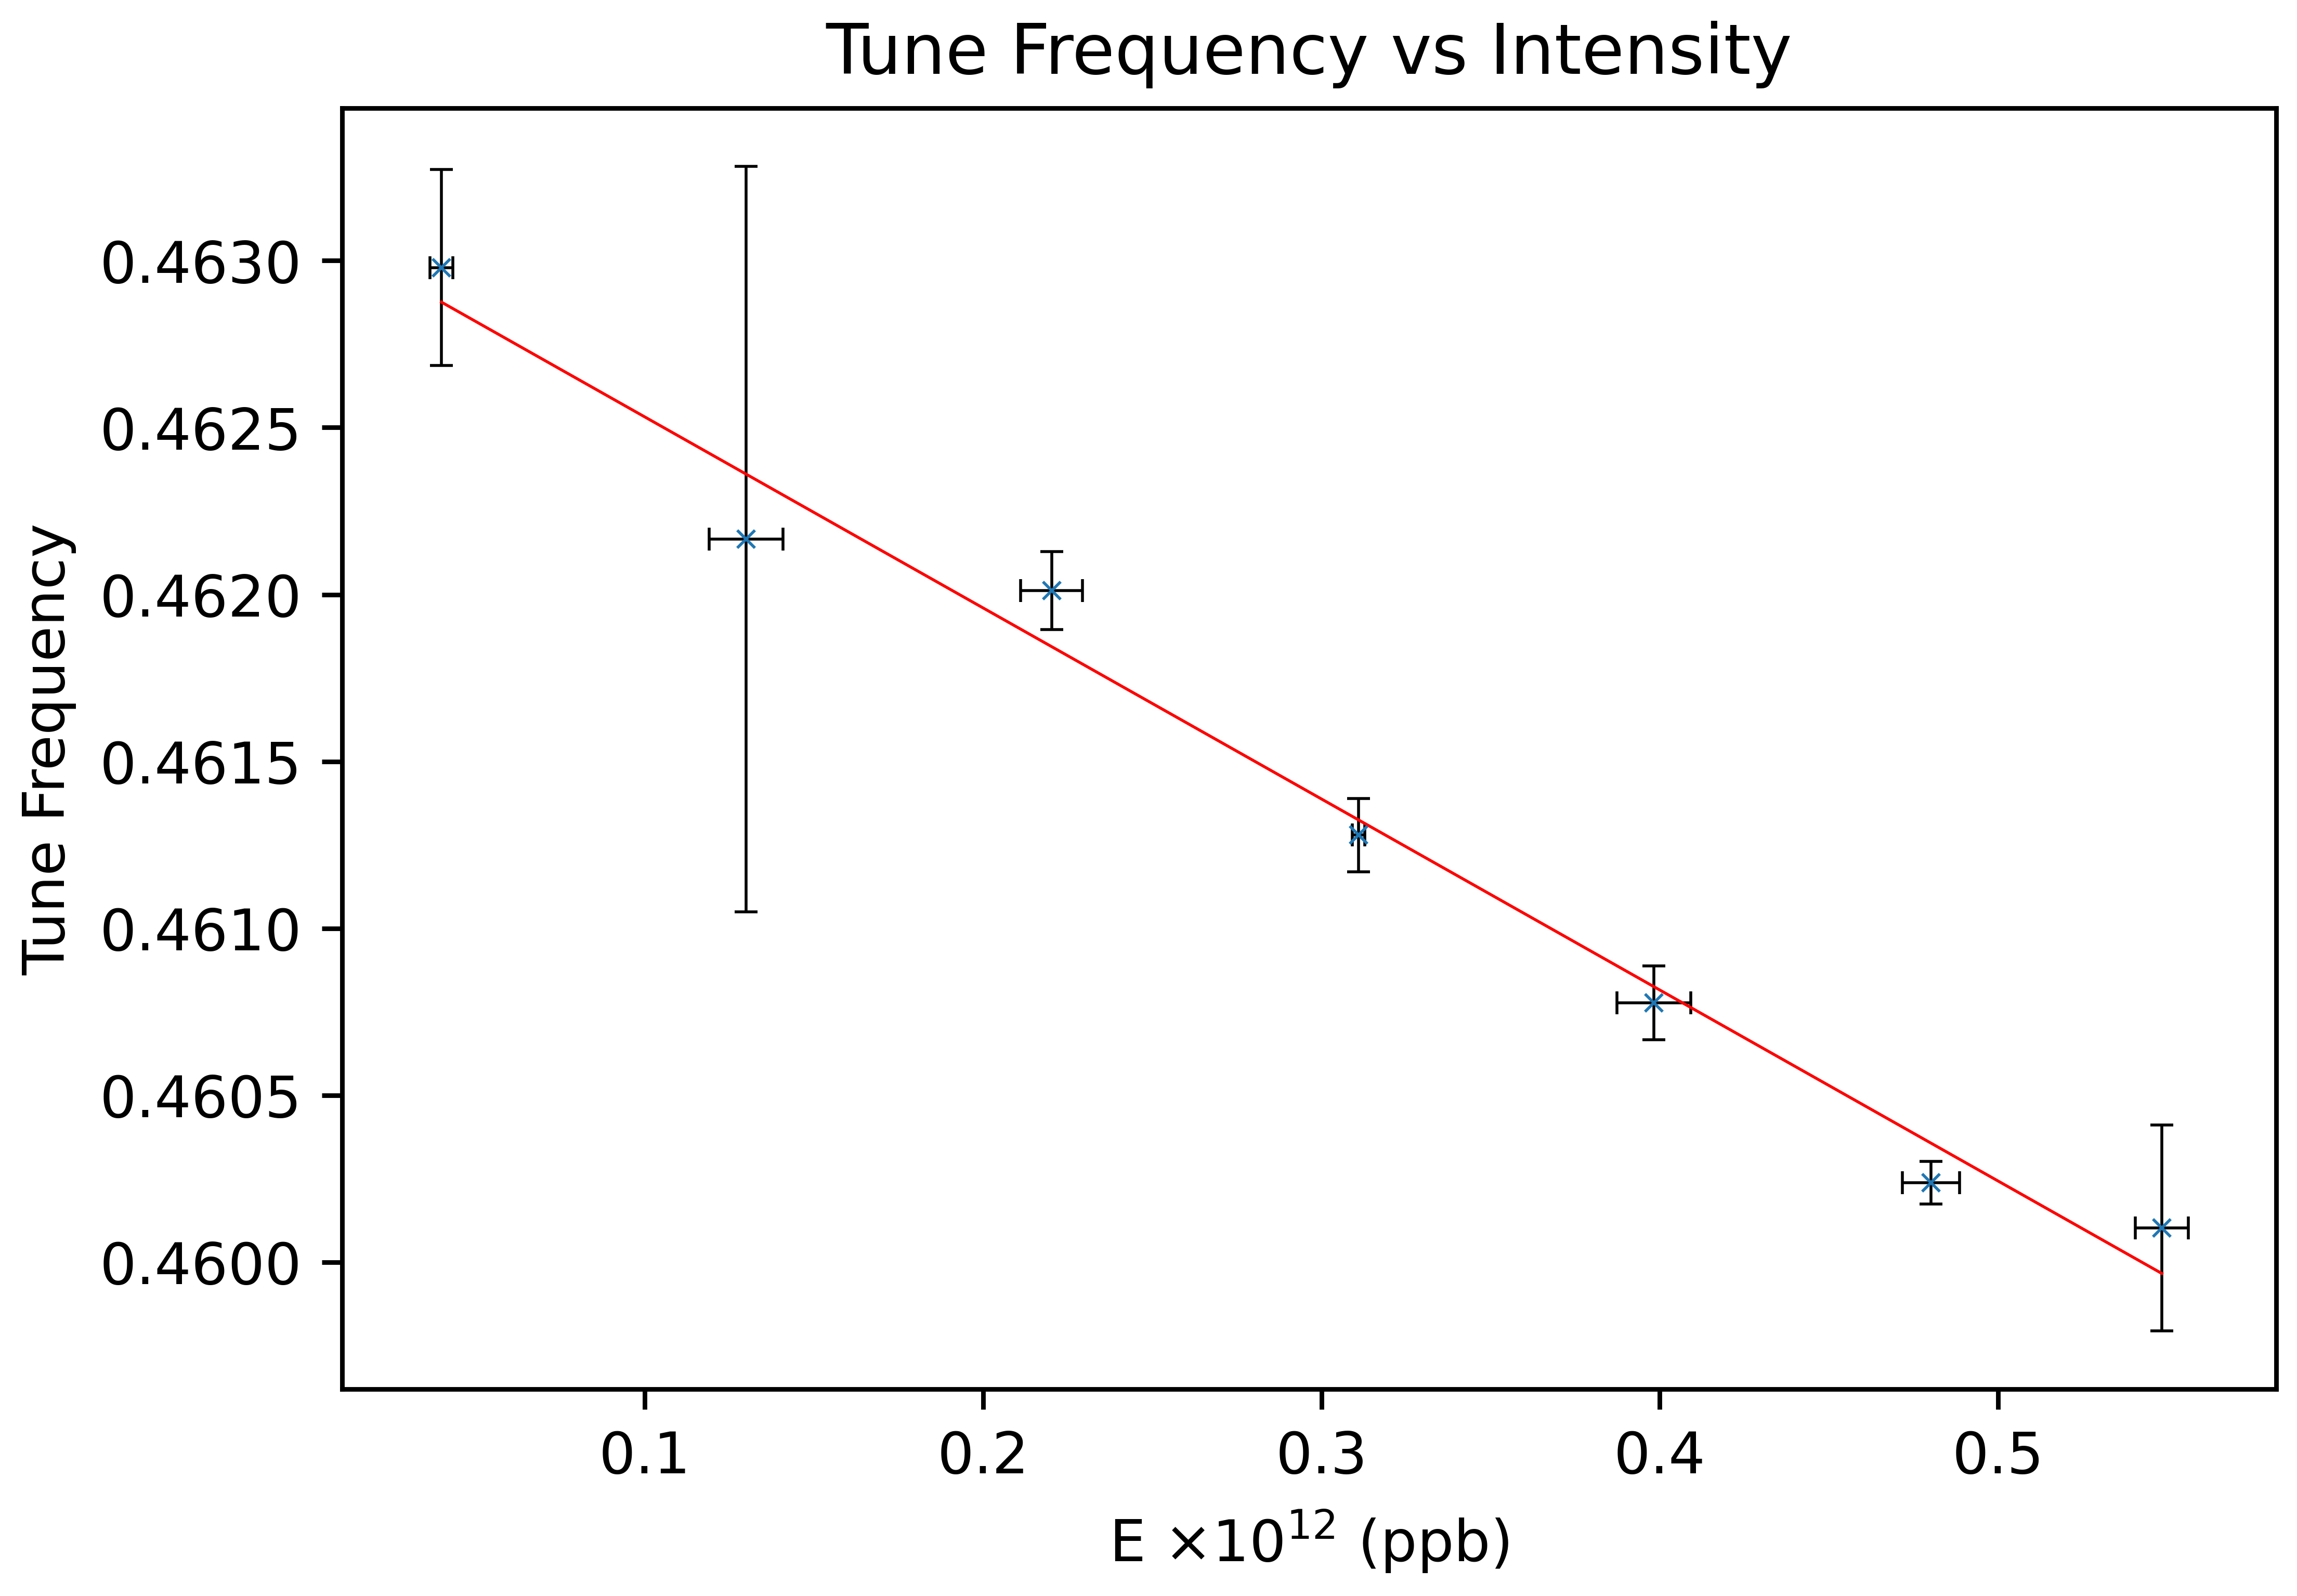

In [13]:
# Regular fitting
a,b = np.polyfit(Intensity_Avg,Max_Frequency_Avg,1)

# Plotting
fig, ax = plt.subplots(figsize=(6,4), dpi=800)
plt.style.use('science')
plt.xlabel(r'E $\times 10^{12}$ (ppb)')
plt.ylabel('Tune Frequency')
plt.title('Tune Frequency vs Intensity')
plt.errorbar(Intensity_Avg,Max_Frequency_Avg,xerr=Intensity_Std,yerr=Max_Frequency_Std, fmt='x', markersize=3, markeredgewidth=0.5, ecolor='black', capsize=2, elinewidth=0.5, capthick=0.5)
plt.plot(Intensity_Avg,a*np.array(Intensity_Avg)+b, label='Linear Fit', color='red', linewidth=0.5)
plt.show()

#### Weighted Fitting

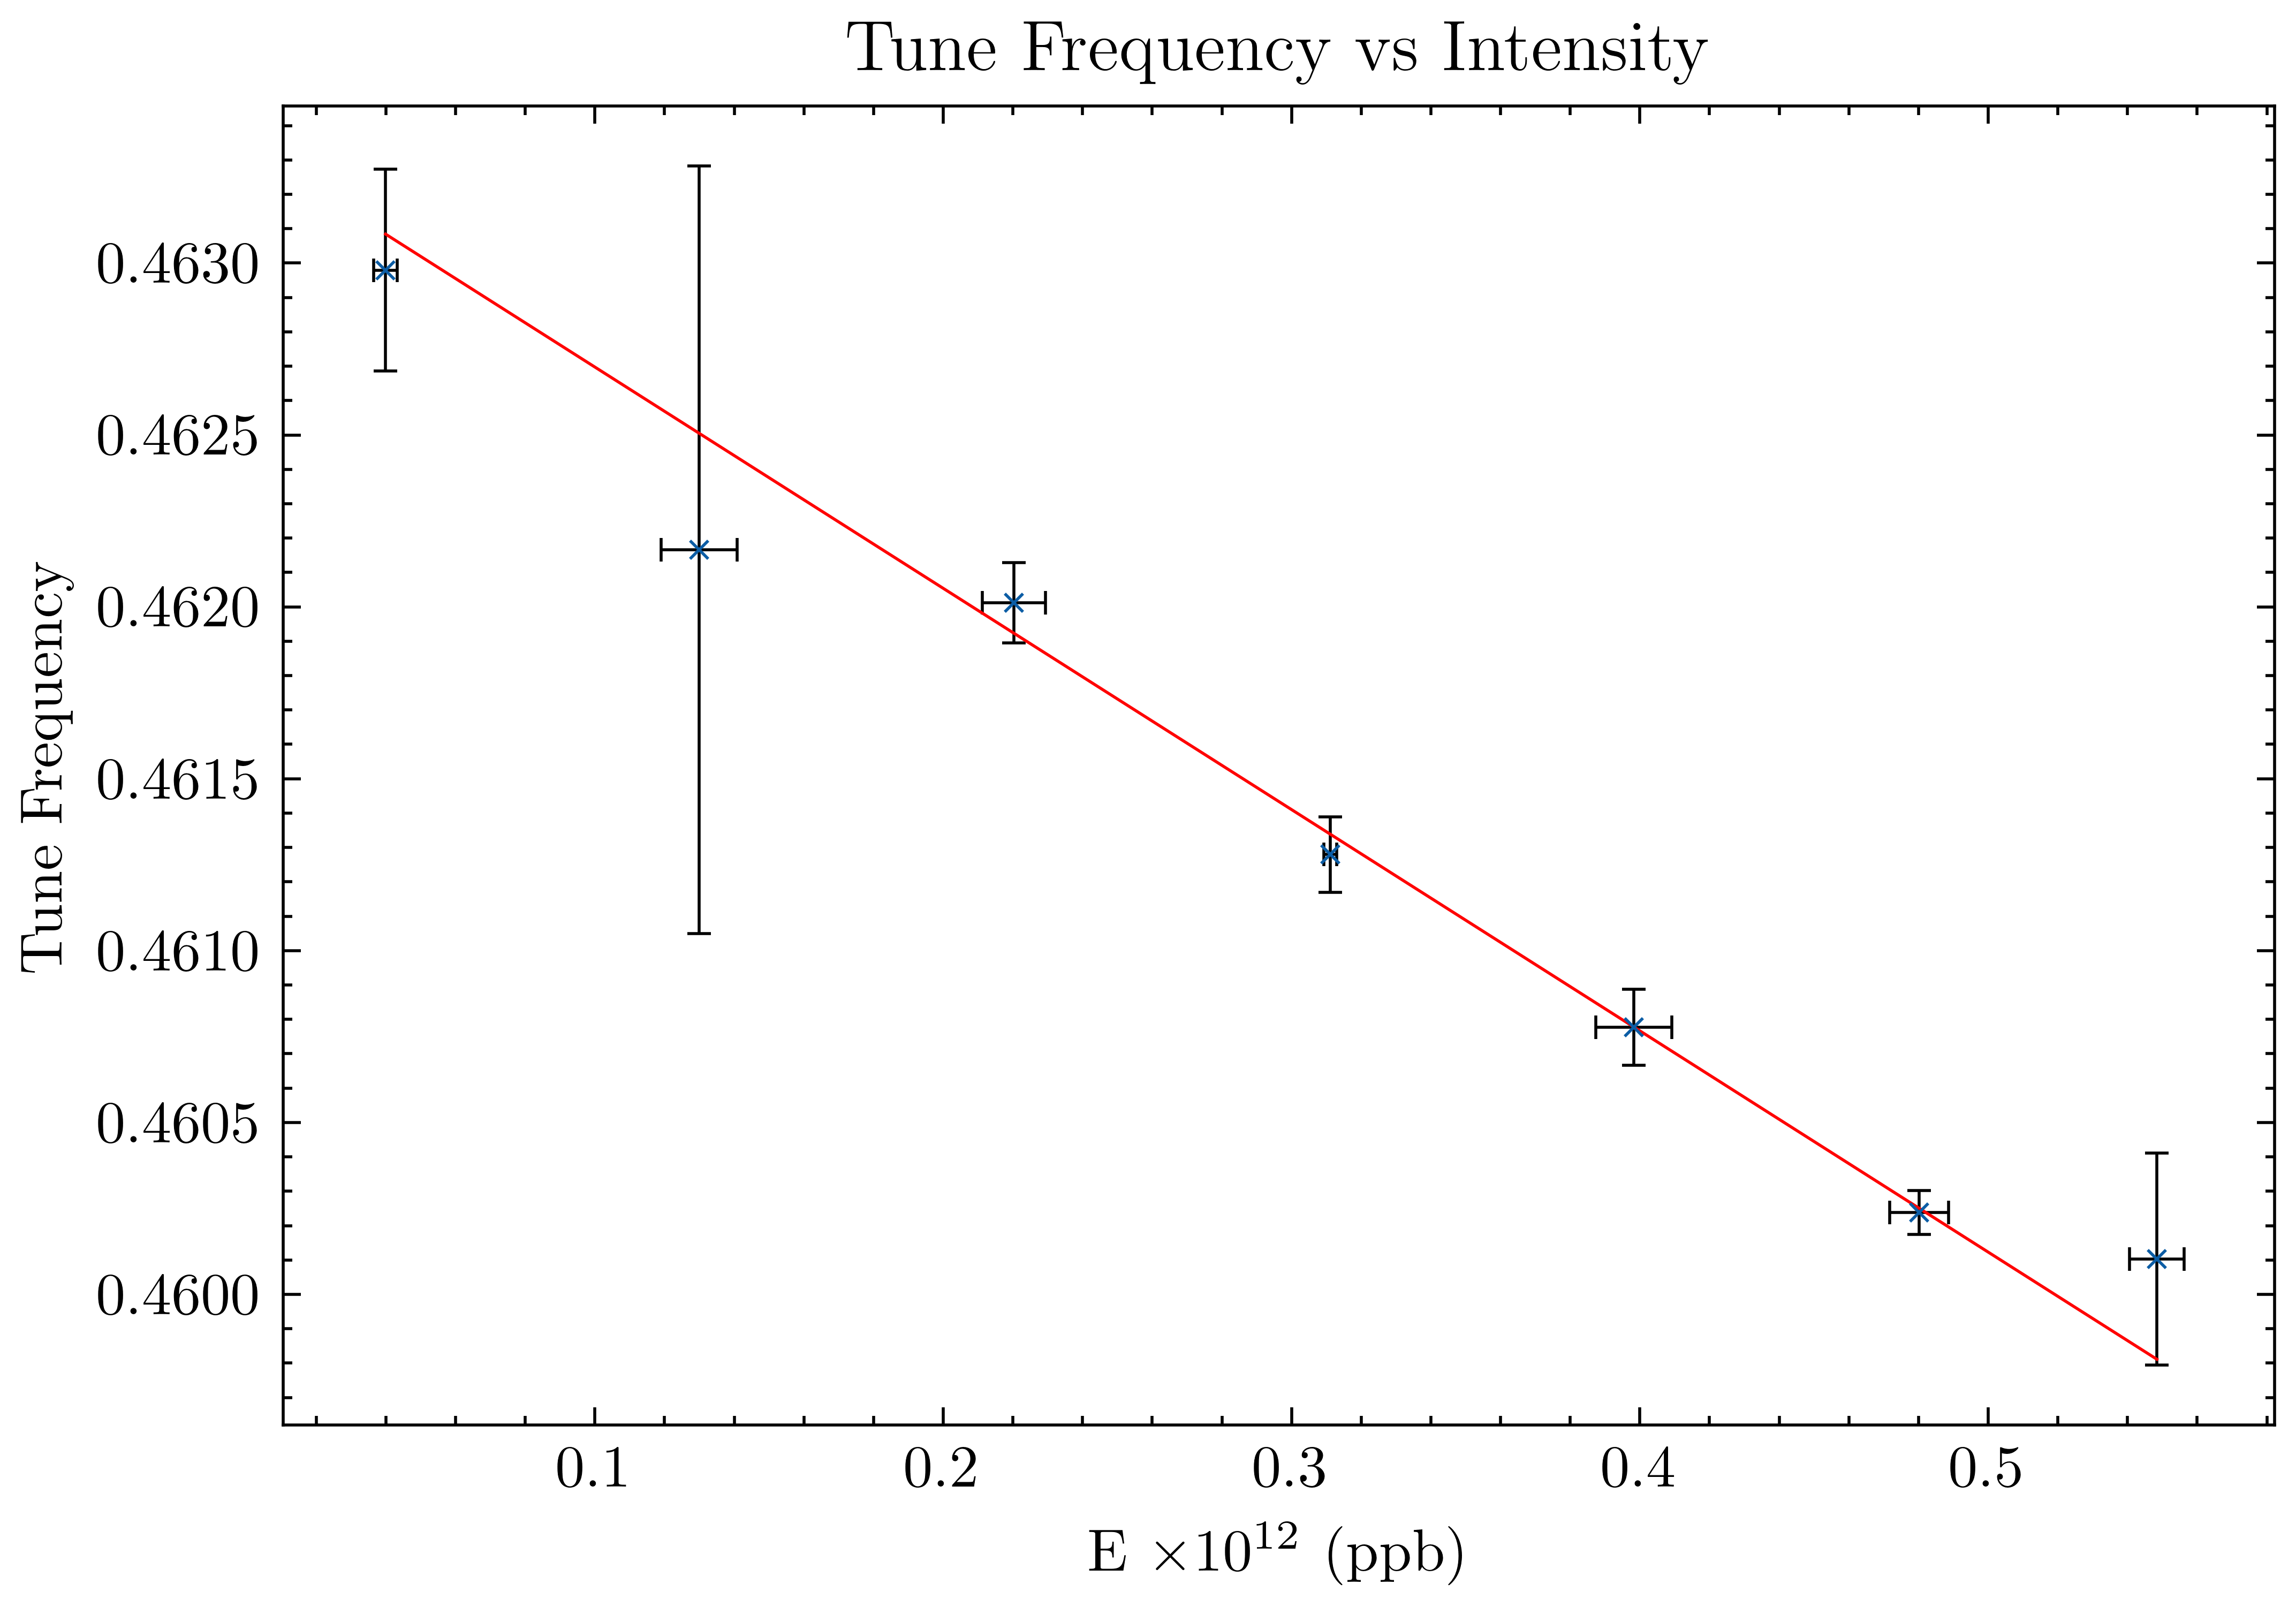

In [14]:
def linear_func(x, a, b):
    return a * x + b

params, _ = curve_fit(
    linear_func, Intensity_Avg, Max_Frequency_Avg, sigma=Max_Frequency_Std, absolute_sigma=True
)
# Extract the fitted parameters
a, b = params
# Plot
fig, ax = plt.subplots(figsize=(6,4), dpi=800)
plt.style.use('science')
plt.xlabel(r'E $\times 10^{12}$ (ppb)')
plt.ylabel('Tune Frequency')
plt.title('Tune Frequency vs Intensity')
plt.errorbar(Intensity_Avg,Max_Frequency_Avg,xerr=Intensity_Std,yerr=Max_Frequency_Std, fmt='x', markersize=3, markeredgewidth=0.5, ecolor='black', capsize=2, elinewidth=0.5, capthick=0.5)
plt.plot(Intensity_Avg,a*np.array(Intensity_Avg)+b, label='Linear Fit', color='red', linewidth=0.5)
plt.show()